<a href="https://colab.research.google.com/github/narfdf999/Arquitectura/blob/master/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import keras
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Conv2DTranspose, Reshape
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model ,Sequential, load_model
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.optimizers import Adam



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [19]:
#Load Dataset
def load_data():
  path = '/content/drive/My Drive/1260_mercator'
  x_train = np.load('/content/drive/My Drive/1260_mercator/01a.npy')

  for filename in glob.glob(os.path.join(path, '*.npy')):
    if(filename != '/content/drive/My Drive/1260_mercator/01a.npy'):
      print(filename)
      aux=np.load(filename)
      print(x_train.shape)
      print(aux.shape)
      x_train=np.concatenate((x_train,aux),axis = 0)  

  return x_train

x_train = load_data()
print(x_train)

/content/drive/My Drive/1260_mercator/01b.npy
(1343, 21, 60)
(1051, 21, 60)
/content/drive/My Drive/1260_mercator/02a.npy
(2394, 21, 60)
(328, 21, 60)
/content/drive/My Drive/1260_mercator/02b.npy
(2722, 21, 60)
(670, 21, 60)
/content/drive/My Drive/1260_mercator/03a.npy
(3392, 21, 60)
(5026, 21, 60)
/content/drive/My Drive/1260_mercator/03b.npy
(8418, 21, 60)
(2591, 21, 60)
/content/drive/My Drive/1260_mercator/03c.npy
(11009, 21, 60)
(1330, 21, 60)
/content/drive/My Drive/1260_mercator/04a.npy
(12339, 21, 60)
(1148, 21, 60)
/content/drive/My Drive/1260_mercator/04b.npy
(13487, 21, 60)
(1200, 21, 60)
/content/drive/My Drive/1260_mercator/04c.npy
(14687, 21, 60)
(826, 21, 60)
/content/drive/My Drive/1260_mercator/09.npy
(15513, 21, 60)
(3322, 21, 60)
/content/drive/My Drive/1260_mercator/10.npy
(18835, 21, 60)
(3027, 21, 60)
/content/drive/My Drive/1260_mercator/12.npy
(21862, 21, 60)
(1709, 21, 60)
/content/drive/My Drive/1260_mercator/14.npy
(23571, 21, 60)
(4942, 21, 60)
/content/dr

In [0]:
np.save('/content/drive/My Drive/1260_mercator/mercator_total.npy',x_train)

In [21]:
#Add Noise to our MNNIST Dataset by sampling random values from Gaussian distribution by using np.random.normal() and adding it to our original images to change pixel values

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
print(x_train_noisy)



[[[-1.06275942e+00 -3.15951529e-01 -4.41657452e-01 ... -1.60270959e-03
   -1.24251739e+00 -3.33667097e-01]
  [-7.32612118e-01 -5.06707648e-01 -1.22520025e+00 ... -1.44239202e-02
   -8.43407220e-01 -1.40113398e+00]
  [-6.22492139e-01 -3.29739773e-01 -1.84913079e+00 ... -8.07926924e-01
   -1.65647618e+00 -3.26326119e-01]
  ...
  [ 5.18513281e-01  1.87080304e-01  4.93972266e-01 ...  5.85377201e-01
    1.31765351e+00  1.00161279e+00]
  [ 1.11441940e+00  1.04289672e+00  1.75142587e+00 ...  7.51896714e-01
    1.47428320e+00  1.14842893e+00]
  [ 7.40045827e-01  1.79567771e+00  5.16070446e-01 ...  7.96036468e-01
    1.53292325e+00  8.27922246e-01]]

 [[-1.06847336e+00 -1.01327148e+00 -8.14788819e-01 ... -5.01709738e-01
   -9.80994351e-01 -4.81501937e-01]
  [-4.90931895e-01 -7.47658949e-01  2.76000995e-02 ... -1.09061846e+00
   -7.70017282e-01 -6.78124578e-01]
  [-3.43955072e-01  3.32348710e-04 -1.35272018e+00 ... -1.36140283e+00
   -8.28724458e-01 -3.64040288e-01]
  ...
  [ 9.21640131e-01  1.0

In [0]:
np.save('/content/drive/My Drive/1260_mercator/mercator_total_noisy1.npy',x_train_noisy)

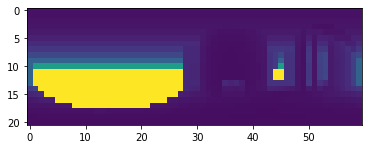

In [59]:
plt.imshow(x_train[100],vmin=-1,vmax=1)

In [0]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [53]:
# input matriz (21,60)
# output array 125
def create_encoder():
  
    encoder=Sequential()

    encoder.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),input_shape=(21,60,1),name='e_conv2d_1'))
    encoder.add(LeakyReLU(alpha=0.2))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),name='e_maxpool_1'))
    
    encoder.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),name='e_conv2d_2'))
    encoder.add(LeakyReLU(alpha=0.2))
    encoder.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),name='e_maxpool_2'))
    
    encoder.add(Flatten())
    encoder.add(Dense(units=128, activation='relu'))
    
    encoder.compile(loss='mse', optimizer=adam_optimizer())
    encoder.name='encoder'
    return encoder
e = create_encoder()
e.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e_conv2d_1 (Conv2D)          (None, 17, 56, 32)        832       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 17, 56, 32)        0         
_________________________________________________________________
e_maxpool_1 (MaxPooling2D)   (None, 16, 55, 32)        0         
_________________________________________________________________
e_conv2d_2 (Conv2D)          (None, 12, 51, 32)        25632     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 12, 51, 32)        0         
_________________________________________________________________
e_maxpool_2 (MaxPooling2D)   (None, 11, 50, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 17600)             0   

In [45]:
# input array 128
# output matriz (21,60)

def create_decoder():

  generator=Sequential()

  generator.add(Dense(128 * 7 * 3, input_dim=128, name='dense'))
  generator.add(Reshape((7, 3, 128), name='reshape'))

  generator.add(Conv2DTranspose(64, (5,5), strides=(3,5), padding='same', name='conv2dt_1'))
  generator.add(Conv2DTranspose(1, (5,5), strides=(1,4), padding='same', name='conv2dt_2'))

  generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
  generator.name='decoder'
  return generator
g = create_decoder()
g.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2688)              346752    
_________________________________________________________________
reshape (Reshape)            (None, 7, 3, 128)         0         
_________________________________________________________________
conv2dt_1 (Conv2DTranspose)  (None, 21, 15, 64)        204864    
_________________________________________________________________
conv2dt_2 (Conv2DTranspose)  (None, 21, 60, 1)         1601      
Total params: 553,217
Trainable params: 553,217
Non-trainable params: 0
_________________________________________________________________


In [63]:
def c_autoencoder(encoder, decoder):

  c_autoencoder_input = Input(shape=(21,60,1))
  x = encoder(c_autoencoder_input)
  p = Input(shape=(3,))
  c_autoencoder_output=decoder(x)
  autoencoder = Model(inputs=[c_autoencoder_input], outputs=c_autoencoder_output)
  autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
  autoencoder.name='cuasi autoencoder'
  return autoencoder

autoencoder=c_autoencoder(e,g)
autoencoder.summary()

Model: "cuasi autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 21, 60, 1)         0         
_________________________________________________________________
encoder (Sequential)         (None, 128)               2279392   
_________________________________________________________________
decoder (Sequential)         (None, 21, 60, 1)         553217    
Total params: 2,832,609
Trainable params: 2,832,609
Non-trainable params: 0
_________________________________________________________________


In [0]:
x_train=np.expand_dims(x_train,axis=-1)
x_train_noisy=np.expand_dims(x_train_noisy,axis=-1)

In [0]:
autoencoder.fit(x_train_noisy, x_train,epochs=100,batch_size=128,shuffle=True,validation_data=(x_train_noisy, x_train),)